Name : Jegakumaran P.                 
Index Number : 190280N

In [2]:
import numpy as np
import cv2 as cv
f=open(r'./Images/templeSparseRing/templeSparseRing/templeSR_par.txt','r')
assert f is not None

n=int(f.readline())
l=f.readline().split()
img1_fn=l[0]

# Reading the information on the first image
K1=np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1=np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1=np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Reading the information on the second image
l=f.readline().split()
img2_fn=l[0]
K2=np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2=np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2=np.array([float(i) for i in l[19:22]]).reshape((3,1))

print("K1 = ",K1)
print("R1 = ",R1)
print("t1 = ",t1)
print("K2 = ",K2)
print("R2 = ",R2)
print("t2 = ",t2)

img1=cv.imread(r'Images/templeSparseRing/templeSparseRing/' + img1_fn,cv.IMREAD_COLOR)
img2=cv.imread(r'Images/templeSparseRing/templeSparseRing/' + img2_fn,cv.IMREAD_COLOR)
assert img1 is not None
assert img2 is not None

K1 =  [[1.5204e+03 0.0000e+00 3.0232e+02]
 [0.0000e+00 1.5259e+03 2.4687e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00]]
R1 =  [[ 0.02187598  0.98329681 -0.18068986]
 [ 0.99856708 -0.01266115  0.05199501]
 [ 0.04883878 -0.18156839 -0.9821648 ]]
t1 =  [[-0.07266377]
 [ 0.02233604]
 [ 0.61460485]]
K2 =  [[1.5204e+03 0.0000e+00 3.0232e+02]
 [0.0000e+00 1.5259e+03 2.4687e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00]]
R2 =  [[-0.034722    0.98429285 -0.17309525]
 [ 0.93942193 -0.02695167 -0.3417017 ]
 [-0.34099974 -0.17447404 -0.92373047]]
t2 =  [[-0.0746307 ]
 [ 0.03381481]
 [ 0.60085057]]


In [7]:
sift=cv.xfeatures2d.SIFT_create()
kp1,decs1=sift.detectAndCompute(img1,None)
kp2,decs2=sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE =1
index_params = dict(algorithm = FLANN_INDEX_KDTREE,trees = 5)
search_params=dict(checks=100)
flann=cv.FlannBasedMatcher(index_params,search_params)
matches=flann.knnMatch(decs1,decs2,k=2)

good=[]
pts1=[]
pts2=[]
for i,(m,n) in enumerate(matches):
    if m.distance<0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1=np.array(pts1)
pts2=np.array(pts2)

F,mask=cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC) # F=Fundamental Matrix

E=K2.T@F@K1 # Essential Matrix
print("Fundamental Matrix = ",F)
print("Essential Matrix = ",E)

retval,R,t,mask = cv.recoverPose(E,pts1,pts2,K1)
R_t_1=np.concatenate((R1,t1),axis=1) # 3 x 4

R2_=R1@R
t2_=R1@t
R_t_2=np.concatenate((R2_,t2_),axis=1) # 3 x 4

P1=K1@np.hstack((R1,t1)) # First Camera Matrix from data read from file
P2_=K2@R_t_2 # Second camera estimated from the fundamental matrix computed via point matches




Fundamental Matrix =  [[ 1.19353197e-06  1.48128487e-05 -2.65668422e-02]
 [-8.37167541e-06  6.34793204e-07  2.04080864e-03]
 [ 2.41439516e-02 -5.73622910e-03  1.00000000e+00]]
Essential Matrix =  [[ 2.75898779e+00  3.43654884e+01 -3.42837514e+01]
 [-1.94221058e+01  1.47803397e+00 -5.08742503e-01]
 [ 3.41148335e+01 -1.68046954e+00 -1.62748485e-02]]


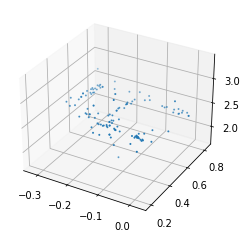

In [9]:
points4d=cv.triangulatePoints(P1,P2_,pts1.T,pts2.T)
points4d /=points4d[3,:]
import matplotlib.pyplot as plt
X=points4d[0,:]
Y=points4d[1,:]
Z=points4d[2,:]
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(X,Y,Z,s=1,cmap='gray')
plt.show()